In [483]:
# %%
import os, sys, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd
import h5py
from scipy import io
import matplotlib.pyplot as plt
import matplotlib.cm
cmap = matplotlib.cm.get_cmap('Reds')

%matplotlib inline

sys.path.append('/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages')
import rsatoolbox
import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
from rsatoolbox.model import ModelFixed
from rsatoolbox.inference import eval_fixed
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import pdist, squareform
import math
import re

## essential function

In [484]:
def load_expect(data_dir, sub, ses ):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_expect = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist: 
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_02expect = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns=['trial_order', 'run_order'],
                            values=['event02_expect_angle']) #, aggfunc='first')
        seswise_02expect.columns  = [col[0]+'_'+str(col[1]) for col in seswise_02expect.columns.values]
        seswise_02expect = seswise_02expect.reset_index()
        seswise_02expect["condition"] = task + '_' + seswise_02expect['param_cue_type'].astype(str) + '_' + seswise_02expect["param_stimulus_type"]

        # reorder values
        seswise_02expect['stim_order'] = seswise_02expect['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})  
        seswise_02expect['cue_order'] = seswise_02expect['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})    
        ses_expect = seswise_02expect.sort_values(['cue_order','stim_order'])
        seswise_expect = pd.concat([seswise_expect, ses_expect])
    return(seswise_expect.reset_index(drop = True))


def load_outcome(data_dir, sub, ses):
    tasklist = ['pain', 'vicarious', 'cognitive']
    seswise_outcome = pd.DataFrame()
    for task in tasklist:
        runwise_df = pd.DataFrame()
        flist = glob.glob(os.path.join(data_dir, sub, ses, f"{sub}_{ses}_*{task}_beh.csv"))
        for f in flist:
            df = pd.read_csv(f)
            df['trial'] = df.index
            df['trial_order'] = df.groupby('param_cond_type', as_index=False)['param_cond_type'].cumcount()
            runwise_df = pd.concat([runwise_df, df])
        # convert run number
        runwise_df['run_order'] = runwise_df['param_run_num'].gt(np.mean(runwise_df['param_run_num']), 0)*1
        seswise_04outcome = runwise_df.pivot_table(index=['param_cue_type','param_stimulus_type'], columns = ['trial_order', 'run_order'],
                            values=['event04_actual_angle']) #, aggfunc='first')
        seswise_04outcome.columns  = [ col[0]+'_'+str(col[1]) for col in seswise_04outcome.columns.values]
        seswise_04outcome = seswise_04outcome.reset_index()
        seswise_04outcome["condition"] = task + '_' + seswise_04outcome['param_cue_type'].astype(str) + '_' + seswise_04outcome["param_stimulus_type"]

        # reorder values
        seswise_04outcome['stim_order'] = seswise_04outcome['param_stimulus_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        seswise_04outcome['cue_order'] = seswise_04outcome['param_cue_type'].map({'high_cue':0, 'low_cue':1, 'high_stim':0, 'med_stim':1, 'low_stim':2})
        ses_outcome = seswise_04outcome.sort_values(['cue_order','stim_order'])
        seswise_outcome = pd.concat([seswise_outcome, ses_outcome])
    return(seswise_outcome.reset_index(drop = True))


def load_fmri(singletrial_dir, sub, ses, run, atlas):
    from nilearn import datasets
    from nilearn.maskers import NiftiLabelsMasker
    dataset = datasets.fetch_atlas_schaefer_2018()
    atlas_filename = dataset.maps
    # labels = dataset.labels
    labels = np.insert(dataset.labels, 0, 'Background')
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                            memory='nilearn_cache', verbose=5)
    if atlas == True: 
        arr = np.empty((0, len(dataset['labels'])), int)  
    elif atlas == False:
        get_shape = glob.glob(os.path.join(
                singletrial_dir, sub, f'{sub}_{ses}_run-01_runtype-*_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz'))
        get_shape_data = image.mean_img(image.concat_imgs(get_shape)).get_fdata().ravel()
        arr = np.empty((0, get_shape_data.shape[0]), int)
    # task_array = np.empty((18,0), int)
    
    for runtype in ['pain','cognitive', 'vicarious']:
        stim_H_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-high.nii.gz')))
        stim_M_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-med.nii.gz')))
        stim_L_cue_H = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-high_stimintensity-low.nii.gz')))
        stim_H_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-high.nii.gz')))
        stim_M_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-med.nii.gz')))
        stim_L_cue_L = sorted(glob.glob(os.path.join(
            singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-stimulus_trial-*_cuetype-low_stimintensity-low.nii.gz')))
        stim_flist = []
        [stim_flist.extend(l) for l in (stim_H_cue_H, stim_M_cue_H, stim_L_cue_H, stim_H_cue_L, stim_M_cue_L, stim_L_cue_L)]

        
        # task_array = np.vstack((task_array, runwise_array))
        # arr = np.append(arr, runwise_array, axis=0)
        if atlas == True:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H))
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H))
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H))
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L))
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L))
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L))
            runwise_array = masker.fit_transform(image.concat_imgs([stim_H_cue_H_mean,
                                                          stim_M_cue_H_mean,
                                                          stim_L_cue_H_mean,
                                                          stim_H_cue_L_mean,
                                                          stim_M_cue_L_mean,
                                                          stim_L_cue_L_mean
                                                           ])) # (trials, parcels)
            arr = np.concatenate((arr,runwise_array),axis=0)
    # np.vstack((arr, runwise_array))
        elif atlas == False:
            stim_H_cue_H_mean = image.mean_img(image.concat_imgs(stim_H_cue_H)).get_fdata().ravel()
            stim_M_cue_H_mean = image.mean_img(image.concat_imgs(stim_M_cue_H)).get_fdata().ravel()
            stim_L_cue_H_mean = image.mean_img(image.concat_imgs(stim_L_cue_H)).get_fdata().ravel()
            stim_H_cue_L_mean = image.mean_img(image.concat_imgs(stim_H_cue_L)).get_fdata().ravel()
            stim_M_cue_L_mean = image.mean_img(image.concat_imgs(stim_M_cue_L)).get_fdata().ravel()
            stim_L_cue_L_mean = image.mean_img(image.concat_imgs(stim_L_cue_L)).get_fdata().ravel()
            runwise_array = np.vstack((stim_H_cue_H_mean, stim_M_cue_H_mean, stim_L_cue_H_mean, stim_H_cue_L_mean, stim_M_cue_L_mean, stim_L_cue_L_mean))
            arr = np.concatenate((arr,runwise_array),axis=0)
        mask = ~np.isnan(image.load_img(image.concat_imgs(stim_H_cue_H)).get_fdata())
    return(mask, arr, stim_flist)

def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

In [485]:
def get_unique_ses(sub_id, singletrial_dir):

    flist = glob.glob(os.path.join(singletrial_dir, sub_id, '*stimulus*trial-000_*.nii.gz'))
    # Initialize empty sets to store unique values of 'ses' and 'run'
    unique_ses = set()
    unique_run = set()

    # Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
    for path in flist:
        # Extract 'ses-##' using regular expression
        ses_match = re.search(r'ses-(\d+)', path)
        if ses_match:
            unique_ses.add(ses_match.group(0))

        # Extract 'run-##' using regular expression
        run_match = re.search(r'run-(\d+)', path)
        if run_match:
            unique_run.add(run_match.group(0))
    # for run in sorted(unique_run):
    #     print(run)
    return unique_ses 

In [102]:
# load brain data
sub_list = ["sub-0003", "sub-0004", "sub-0005", "sub-0006", "sub-0009",    "sub-0010",    "sub-0018",    "sub-0025",    "sub-0029",    "sub-0031",    "sub-0032",    "sub-0033",    "sub-0034",    "sub-0036",    "sub-0037",    "sub-0038",    "sub-0039",    "sub-0043",    "sub-0044",    "sub-0046",    "sub-0050",    "sub-0051",    "sub-0052",    "sub-0053",    "sub-0055",    "sub-0056",    "sub-0057",    "sub-0058",    "sub-0060",    "sub-0061",    "sub-0062",    "sub-0065",    "sub-0073",
    "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090",    "sub-0091",    "sub-0092",    "sub-0093",    "sub-0094",    "sub-0095",    "sub-0098",    "sub-0099",    "sub-0100",    "sub-0101",    "sub-0102",    "sub-0104",    "sub-0105",    "sub-0106",    "sub-0107",    "sub-0109",    "sub-0115",    "sub-0116",    "sub-0122",    "sub-0124",    "sub-0126",    "sub-0127",    "sub-0128",    "sub-0129",    "sub-0130",    "sub-0132",    "sub-0133"]
sub_list = [ "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090"]
# sub_list = ['sub-0061']
ses_list = ['ses-01', 'ses-03', 'ses-04']  # , 'ses-04']
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        # load behavioral data expectation rating
        expect_df = pd.DataFrame()
        expect_df = load_expect(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                sub=sub, ses=ses)
        obs_des = {'pattern': np.array(expect_df.condition)}
        chn_des = {'ratings': np.array(
            ['ratings_' + str(x) for x in np.arange(4)])}
        beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
                                      descriptors=des,
                                      obs_descriptors=obs_des,
                                      channel_descriptors=chn_des))
        # load behavioral data outcome rating
        outcome_df = load_outcome(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                  sub=sub, ses=ses)
        beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
                                       descriptors=des,
                                       obs_descriptors=obs_des,
                                       channel_descriptors=chn_des))
        # load fMRI data
        mask, fmri_df, stim_flist = load_fmri(singletrial_dir='/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                                              sub=sub, ses=ses, run='*', atlas=True)
        obs_des = {'pattern': np.array(expect_df.condition)}
        rsd_data = rsd.Dataset(measurements=fmri_df,
                                     descriptors=des,
                                     obs_descriptors=obs_des,
                                     channel_descriptors={'roi': np.array(['roi_' + str(x) for x in np.arange(fmri_df.shape[1])])})
        fmri_data.append(rsd_data)
        rsd_data.save(f"{sub}_{ses}_RDM.hdf5")
# get mask
# get searchlight_RDM


[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f84aa04f460>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x7f84aa04f070>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels': None,
  'labels_img': '/Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memo

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [157]:
# load brain data
sub_list = ["sub-0003", "sub-0004", "sub-0005", "sub-0006", "sub-0009",    "sub-0010",    "sub-0018",    "sub-0025",    "sub-0029",    "sub-0031",    "sub-0032",    "sub-0033",    "sub-0034",    "sub-0036",    "sub-0037",    "sub-0038",    "sub-0039",    "sub-0043",    "sub-0044",    "sub-0046",    "sub-0050",    "sub-0051",    "sub-0052",    "sub-0053",    "sub-0055",    "sub-0056",    "sub-0057",    "sub-0058",    "sub-0060",    "sub-0061",    "sub-0062",    "sub-0065",    "sub-0073",
    "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090",    "sub-0091",    "sub-0092",    "sub-0093",    "sub-0094",    "sub-0095",    "sub-0098",    "sub-0099",    "sub-0100",    "sub-0101",    "sub-0102",    "sub-0104",    "sub-0105",    "sub-0106",    "sub-0107",    "sub-0109",    "sub-0115",    "sub-0116",    "sub-0122",    "sub-0124",    "sub-0126",    "sub-0127",    "sub-0128",    "sub-0129",    "sub-0130",    "sub-0132",    "sub-0133"]
sub_list = [ "sub-0078",    "sub-0080",    "sub-0081",    "sub-0086",    "sub-0087",    "sub-0090"]
# sub_list = ['sub-0061']
sub_list = [ "sub-0080"]
ses_list = [ 'ses-04']  # , 'ses-04']'ses-01', 'ses-03',
beh_expect = []
beh_outcome = []
fmri_data = []
for sub in sub_list:
    for ses in ses_list:
        des = {'session': ses, 'subj': sub}
        # load behavioral data expectation rating
        expect_df = pd.DataFrame()
        expect_df = load_expect(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
                                sub=sub, ses=ses)
        # obs_des = {'pattern': np.array(expect_df.condition)}
        # chn_des = {'ratings': np.array(
        #     ['ratings_' + str(x) for x in np.arange(4)])}
        # beh_expect.append(rsd.Dataset(measurements=np.array(expect_df.filter(regex='event02_')),
        #                               descriptors=des,
        #                               obs_descriptors=obs_des,
        #                               channel_descriptors=chn_des))
        # # load behavioral data outcome rating
        # outcome_df = load_outcome(data_dir='/Users/h/Dropbox/projects_dropbox/social_influence_analysis/data/beh/beh02_preproc/',
        #                           sub=sub, ses=ses)
        # beh_outcome.append(rsd.Dataset(measurements=np.array(outcome_df.filter(regex='event04_')),
        #                                descriptors=des,
        #                                obs_descriptors=obs_des,
        #                                channel_descriptors=chn_des))
        # load fMRI data
        mask, fmri_df, stim_flist = load_fmri(singletrial_dir='/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/',
                                              sub=sub, ses=ses, run='*', atlas=True)
        obs_des = {'pattern': np.array(expect_df.condition)}
        rsd_data = rsatoolbox.data.Dataset(measurements=fmri_df,
                                     descriptors=des,
                                     obs_descriptors=obs_des,
                                     channel_descriptors={'roi': np.array(['roi_' + str(x) for x in np.arange(fmri_df.shape[1])])})
        fmri_data.append(rsd_data)
        rsd_data.save(filename = f"{sub}_{ses}_RDM.pkl", file_type = 'pkl', overwrite = True)



[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
[Memory]0.5s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]53.0s, 0.9min   : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.wrapped] loading data from /Users/h/nilearn_data/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
[Memory]114.7s, 1.9min  : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


### load pkl and concat RDM

In [486]:
fmri_data = []
# load pkl
pkl_dir = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/scripts/step10_nilearn/RSA'
flist = glob.glob(os.path.join(pkl_dir, f"*.pkl"))
# fname = '/Users/h/Dropbox/projects_dropbox/social_influence_analysis/scripts/step10_nilearn/RSA/sub-0078_ses-01_RDM.pkl'
# append with 
for fname in flist:
    obj = pd.read_pickle(fname)
    des = {'session': os.path.basename(fname).split('_')[1], 
           'subj': os.path.basename(fname).split('_')[0]}
    # rdm_pkl = rsatoolbox.data.Dataset(obj)
    # fmri_data = rsatoolbox.rdm.rdms.rdms_from_dict(obj)
    rdm_dict = rsatoolbox.data.Dataset(measurements=obj['measurements'],
                                     descriptors=des,
                                     obs_descriptors=obj['obs_descriptors'],
                                     channel_descriptors=obj['channel_descriptors'])
#     rdms_fmri = rsr.calc_rdm(rdm_dict)
    fmri_data.append(rdm_dict)


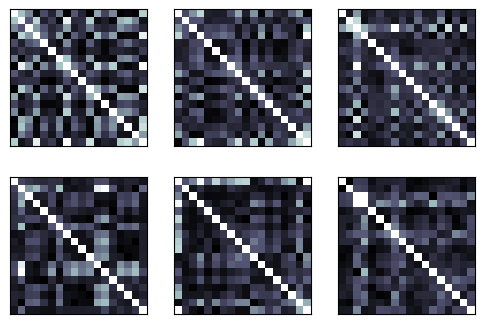

In [487]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(rsr.calc_rdm(fmri_data))
fig.savefig('temp_rdm.png', bbox_inches='tight', dpi=300)

In [488]:
obj.keys()

dict_keys(['measurements', 'descriptors', 'obs_descriptors', 'channel_descriptors', 'type', 'rsatoolbox_version'])

## subjectwise RDM

In [ ]:
rdms_expect = rsr.calc_rdm(beh_expect)
rdms_outcome = rsr.calc_rdm(beh_outcome)
rdms_fmri = rsr.calc_rdm(fmri_data)
noise_prec_shrink = rsatoolbox.data.noise.prec_from_measurements(fmri_data, obs_desc='pattern', method='shrinkage_eye')
rdm_fmri_maha_shrink = rsatoolbox.rdm.calc_rdm(fmri_data, descriptor='pattern', method='mahalanobis', noise=noise_prec_shrink)

rsatoolbox.vis.show_rdm(rdms_expect)
rsatoolbox.vis.show_rdm(rdms_outcome)
rsatoolbox.vis.show_rdm(rdms_fmri)
rsatoolbox.vis.show_rdm(rdm_fmri_maha_shrink)

## categorical RDM

### 1) model_cuestim

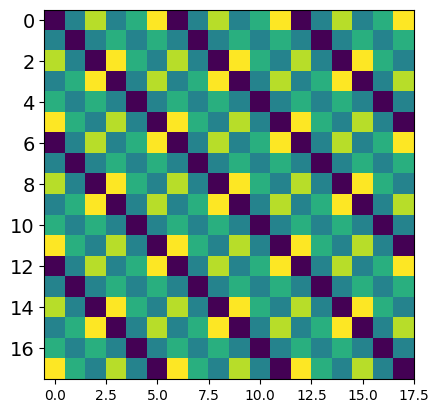

In [491]:
import numpy as np

# Generate the meshgrid
c, t, s = np.meshgrid(np.arange(0,2), np.arange(-1,2), np.arange(-1, 2))

s_2d = s.reshape(-1, 1)
c_2d = c.reshape(-1, 1)
t_2d = t.reshape(-1, 1)

xyz_cue = np.hstack((s_2d, c_2d)) # ,t_2d))
# plt.imshow(xyz_cue)

model_features = rsatoolbox.data.Dataset(np.array(xyz_cue))
model_cuestim = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_cuestim = squareform(pdist(xyz_cue))
plt.imshow(squareform(pdist(xyz_cue)))



## ver 2)  not sure if we should include this

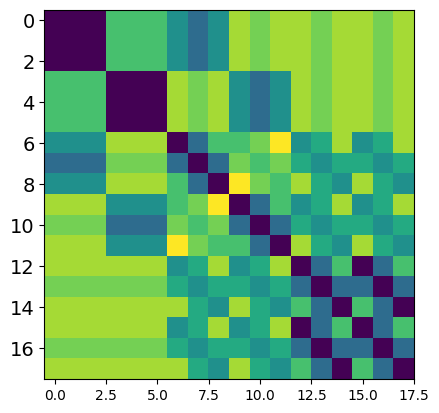

In [418]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

cst = np.vstack((c,s,t)).T
plt.imshow(cst)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(cst[:6,], c1), c1.T),
    np.dot(np.dot(cst[6:12,], c2), c2.T),
    np.dot(np.dot(cst[12:,], c3), c3.T)], axis=0)
plt.imshow(xy)
rdm = squareform(pdist(xy))
plt.imshow(rdm)


## ver 3) model_orthogonal

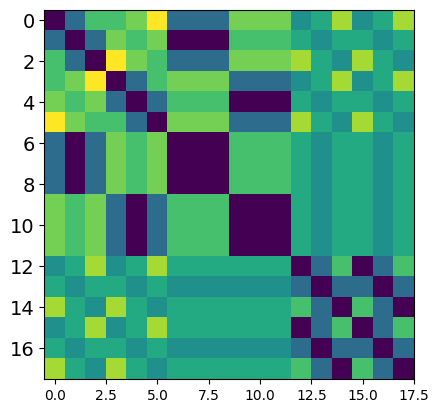

In [492]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(cst)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c1), c1.T),
    np.dot(np.dot(tcs[6:12,], c2), c2.T),
    np.dot(np.dot(tcs[12:,], c3), c3.T)], axis=0)

xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c3), c3.T),
    np.dot(np.dot(tcs[6:12,], c2), c2.T),
    np.dot(np.dot(tcs[12:,], c1), c1.T)], axis=0)


plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_orthogonal = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_orthogonal = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### model_stimtask

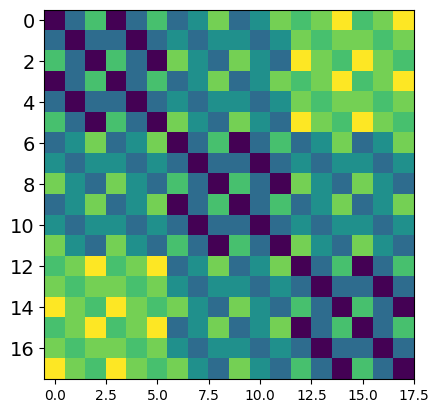

In [493]:

stim = np.array([1,2,3])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c1), c1.T),
    np.dot(np.dot(tcs[6:12,], c1), c1.T),
    np.dot(np.dot(tcs[12:,], c1), c1.T)], axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_stimtask = rsatoolbox.rdm.calc_rdm(model_features)


# rdm_stimtask = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### 4) model_cue

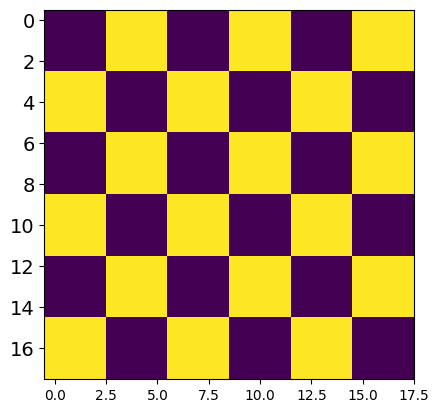

In [494]:

stim = np.array([1, 0, -1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(cst))
# plt.imshow(rdm)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
xy = np.concatenate([
    np.dot(np.dot(tcs[:6,], c4), c4.T),
    np.dot(np.dot(tcs[6:12,], c4), c4.T),
    np.dot(np.dot(tcs[12:,], c4), c4.T)], axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_cue = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_cue = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### grid model_grid

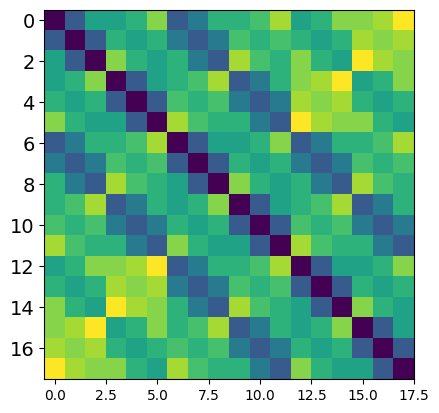

In [495]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)

model_features = rsatoolbox.data.Dataset(np.array(tcs))
model_grid = rsatoolbox.rdm.calc_rdm(model_features)

# rdm_grid = squareform(pdist(tcs))
plt.imshow(squareform(pdist(tcs)))


### rotation grid

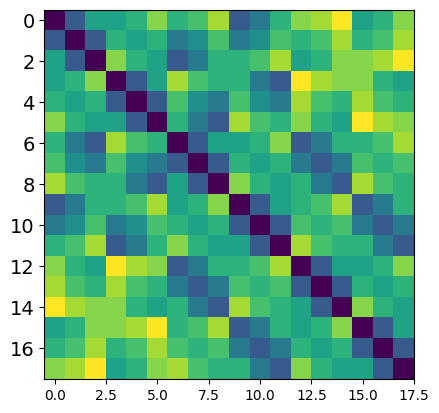

In [496]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)

c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
rot = np.array([[1,0,0],
                [0, np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))],
                [0, -np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])

xy = np.concatenate([
    np.dot(tcs[:6,], rot),
    tcs[6:12,],
    tcs[12:,]],
    axis=0)
plt.imshow(xy)

model_features = rsatoolbox.data.Dataset(np.array(xy))
model_rotationgrid = rsatoolbox.rdm.calc_rdm(model_features)

# rdm = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### diagonal

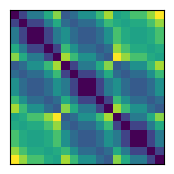

In [497]:

stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
# plt.imshow(tcs)
P = np.array([[1,0],[0, np.cos(np.deg2rad(45))],[0, np.sin(np.deg2rad(45))]])
xy = np.dot(tcs, P)
# plt.imshow(xy)
model_features = rsatoolbox.data.Dataset(np.array(xy))
model_diagonal = rsatoolbox.rdm.calc_rdm(model_features)

rsatoolbox.vis.rdm_plot.show_rdm(model_diagonal)

# rdm_diagonal = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


### model_parallel

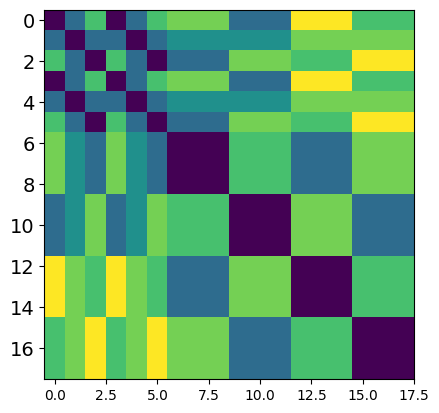

In [573]:
stim = np.array([1,0,-1])
cue = np.array([ 1, 1, 1, -1, -1, -1])
task = np.array([1, 0, -1])
t = np.repeat(task, 6)
s = np.tile(stim, 6)
c = np.tile(cue, 3)

tcs = np.vstack((t,c,s)).T
plt.imshow(tcs)
# rdm = squareform(pdist(tcs))
# plt.imshow(rdm)


c1 = np.array([[1,0,0],
              [0,0,0],
              [0,0,1]])
c2 = np.array([[1,0,0],
              [0,1,0],
              [0,0,0]])
c3 = np.array([[0,0,0],
              [0,1,0],
              [0,0,1]])
c4 = np.array([[0,0,0],
              [0,1,0],
              [0,0,0]])
c5 = np.array([[0,0,0],
              [0,0,0],
              [0,0,1]])
rot = np.array([[1,0,0],
                [0, np.cos(np.deg2rad(90)), np.sin(np.deg2rad(90))],
                [0, -np.sin(np.deg2rad(90)), np.cos(np.deg2rad(90))]])
result = np.dot(np.dot(tcs[:6,], c1), rot)
xy = np.concatenate([
    result,
    np.dot(tcs[6:12,], c2),
    np.dot(tcs[12:,], c2)], axis=0)

# xy = np.dot(np.dot(tcs, rot), rot.T)
# plt.imshow(xy)

model_feaures = rsatoolbox.data.Dataset(np.array(xy))
model_parallel = rsatoolbox.rdm.calc_rdm(model_feaures)

# rdm_parallel = squareform(pdist(xy))
plt.imshow(squareform(pdist(xy)))


In [575]:
model_parallel

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
squared euclidean
dissimilarities = 
[[0.33333333 1.33333333 0.         0.33333333 1.33333333 1.66666667
  1.66666667 1.66666667 0.33333333 0.33333333 0.33333333 2.66666667
  2.66666667 2.66666667 1.33333333 1.33333333 1.33333333 0.33333333
  0.33333333 0.         0.33333333 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 1.66666667 1.66666667 1.66666667
  1.66666667 1.66666667 1.66666667 1.33333333 0.33333333 0.
  0.33333333 0.33333333 0.33333333 1.66666667 1.66666667 1.66666667
  1.33333333 1.33333333 1.33333333 2.66666667 2.66666667 2.66666667
  0.33333333 1.33333333 1.66666667 1.66666667 1.66666667 0.33333333
  0.33333333 0.33333333 2.66666667 2.66666667 2.66666667 1.33333333
  1.33333333 1.33333333 0.33333333 0.66666667 0.66666667 0.66666667
  0.66666667 0.66666667 0.66666667 1.66666667 1.66666667 1.66666667
  1.66666667 1.66666667 1.66666667 0.33333333 0.33333333 0.33333333
  1.66666667 1.66666667 1.66666667 1.3333

In [ ]:
# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_' + str(x) for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
#obs_des = {'conds': np.array(['cond_' + str(x) for x in np.arange(1,nCond+1)])} # indices from 1
#chn_des = {'conds': np.array(['voxel' + str(x) for x in np.arange(1,nVox+1)])} # indices from 1
data = rsd.Dataset(measurements=measurements,
                           descriptors=des,
                           obs_descriptors=obs_des,
                           channel_descriptors=chn_des)
print(data)

## RDM compare
https://rsatoolbox.readthedocs.io/en/stable/comparing.html
https://rsatoolbox.readthedocs.io/en/latest/demo_bootstrap.html#Exercise-1:-Data-and-RDM-handling

In [214]:
models = rsatoolbox.rdm.concat([
    model_cuestim,
    model_orthogonal,
    model_stimtask,
    model_cue,
    model_grid,
    model_rotationgrid,
    model_diagonal,
    model_parallel])
model = rsatoolbox.model.ModelWeighted('test', models)

data_rdms = rsatoolbox.rdm.calc_rdm(fmri_data)
theta = model.fit(data_rdms, method = 'cosine')

In [504]:
models = rsatoolbox.rdm.concat([
    # model_cuestim,
    model_orthogonal,
    # model_stimtask,
    model_cue,
    model_grid,
    model_rotationgrid,
    model_diagonal,
    model_parallel])
models.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
models.pattern_descriptors['cond_names'] = expect_df.condition
# models.shape

In [505]:
type(models)

rsatoolbox.rdm.rdms.RDMs

In [546]:
rdm_orthogonal = rsatoolbox.model.ModelWeighted('orthogonal', model_orthogonal)
rdm_cue = rsatoolbox.model.ModelWeighted('cue', model_cue)
rdm_grid = rsatoolbox.model.ModelWeighted('grid', model_grid)
rdm_rotationgrid = rsatoolbox.model.ModelWeighted('rotationgrid', model_rotationgrid)
rdm_diagonal = rsatoolbox.model.ModelWeighted('diagonal', model_diagonal)
rdm_parallel = rsatoolbox.model.ModelWeighted('parallel', model_parallel)


In [478]:
model_rdms = []
model_rdms = rdm_orthogonal
model_rdms.append(rdm_cue)
model_rdms.append(rdm_grid)
model_rdms.append(rdm_rotationgrid)
model_rdms.append(rdm_diagonal)
model_rdms.append(rdm_parallel)
model_rdms.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
model_rdms.pattern_descriptors['cond_names'] = expect_df.condition

AttributeError: 'ModelFixed' object has no attribute 'append'

In [513]:
model_orthogonal.dissimilarities[0].shape

(153,)

In [517]:
rdm_model.shape

(6, 153)

In [516]:
rdm_model = np.vstack([model_orthogonal.dissimilarities[0],
                       model_cue.dissimilarities[0],
                       model_grid.dissimilarities[0],
                       model_rotationgrid.dissimilarities[0],
                       model_diagonal.dissimilarities[0],
                       model_parallel.dissimilarities[0]])

In [ ]:
models = []
model_names = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

In [482]:

model_rdms = []
model_rdms = model_orthogonal
model_rdms.append(model_cue)
model_rdms.append(model_grid)
model_rdms.append(model_rotationgrid)
model_rdms.append(model_diagonal)
model_rdms.append(model_parallel)
model_rdms.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
model_rdms.pattern_descriptors['cond_names'] = expect_df.condition


AssertionError: appended descriptors misses key model_names

(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493ab2610>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493a7a0a0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493aab2b0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493acebb0>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f8493a2f940>},
              <AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f84939fe6a0>}}))

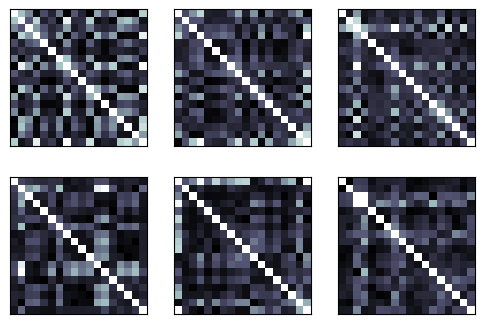

In [265]:
rsatoolbox.vis.show_rdm(data_rdms)

In [ ]:
rsatoolbox.vis.show_rdm(model_rdms, 
                        rdm_descriptor='model_names')
                        #, pattern_descriptor = 'cond_names')

(<Figure size 600x400 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'orthogonal'}>,
         <AxesSubplot:title={'center':'cue'}>,
         <AxesSubplot:title={'center':'grid'}>],
        [<AxesSubplot:title={'center':'rotationgrid'}>,
         <AxesSubplot:title={'center':'diagonal'}>,
         <AxesSubplot:title={'center':'parallel'}>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:title={'center':'orthogonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f849ed4f0a0>},
              <AxesSubplot:title={'center':'cue'}>: {'image': <matplotlib.image.AxesImage at 0x7f849fc9bcd0>},
              <AxesSubplot:title={'center':'grid'}>: {'image': <matplotlib.image.AxesImage at 0x7f849efa6be0>},
              <AxesSubplot:title={'center':'rotationgrid'}>: {'image': <matplotlib.image.AxesImage at 0x7f849ed2c0a0>},
              <AxesSubplot:title={'center':'diagonal'}>: {'image': <matplotlib.image.AxesImage at 0x7f84a0ce5340>},
              <AxesSubplot:title={'center

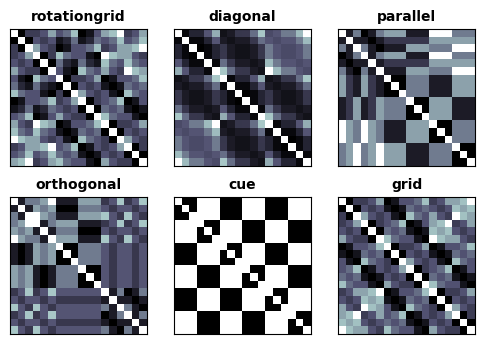

In [506]:
rsatoolbox.vis.show_rdm(models, 
                        rdm_descriptor='model_names')
                        #, pattern_descriptor = 'cond_names')

In [550]:
rdm_orthogonal

In [554]:
model_test = []
model_test.append((
    rdm_orthogonal,
    # model_stimtask,
    rdm_cue,
    rdm_grid,
    rdm_rotationgrid,
    rdm_diagonal,
    rdm_parallel))
# model_test.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
# model_test.pattern_descriptors['cond_names'] = expect_df.condition

In [549]:
models = rsatoolbox.rdm.concat([
    # model_cuestim,
    rdm_orthogonal,
    # model_stimtask,
    rdm_cue,
    rdm_grid,
    rdm_rotationgrid,
    rdm_diagonal,
    rdm_parallel])
models.rdm_descriptors['model_names'] = ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
models.pattern_descriptors['cond_names'] = expect_df.condition
# models.shape

AssertionError: Supply list of RDMs objects, or RDMs objects as separate arguments

(<Figure size 1250x1000 with 2 Axes>, <Axes:>, <Axes:>)

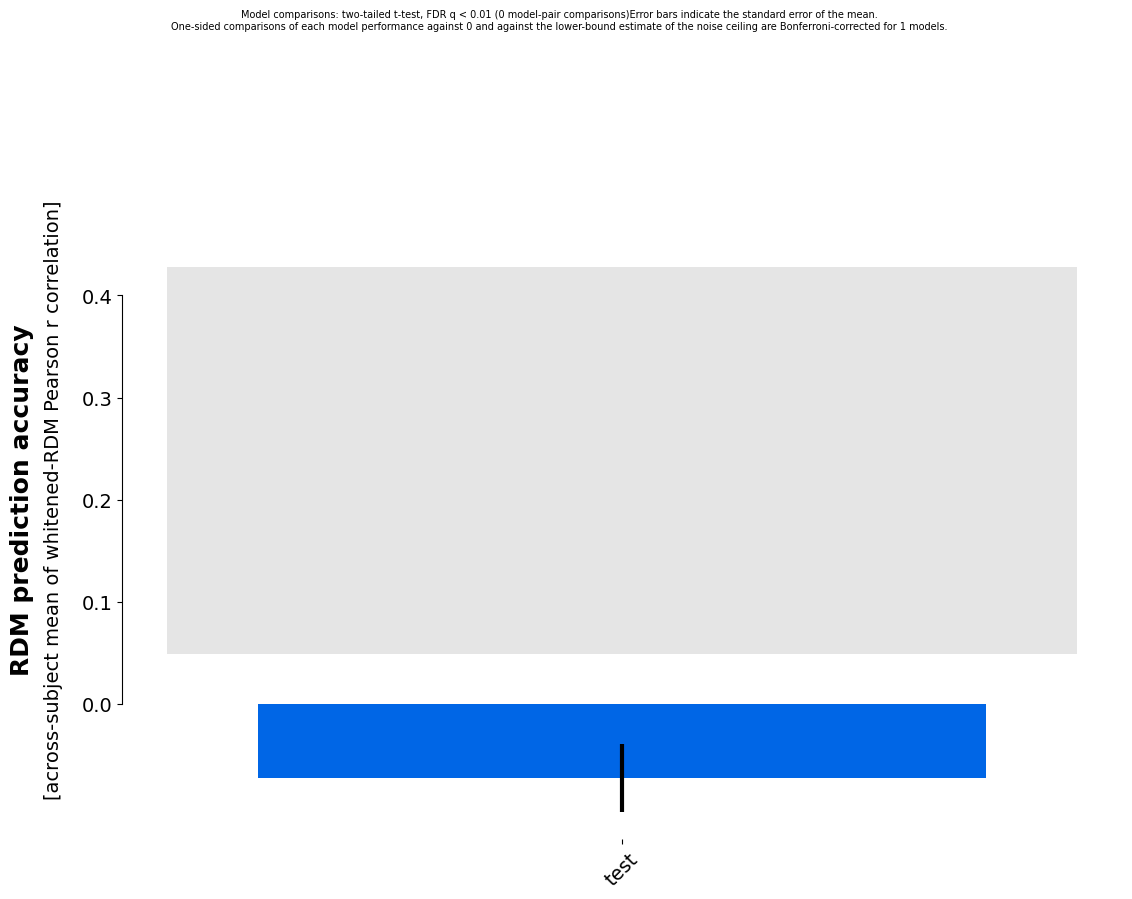

In [523]:
model_test = rsatoolbox.model.ModelWeighted('test', models)
results = rsatoolbox.inference.eval_fixed(model_test, data_rdms, method='corr_cov')
rsatoolbox.vis.plot_model_comparison(results)

In [415]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('model_names', i_model).subset('measurement_model','complete')
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

rsatoolbox.rdm.rdms.RDMs

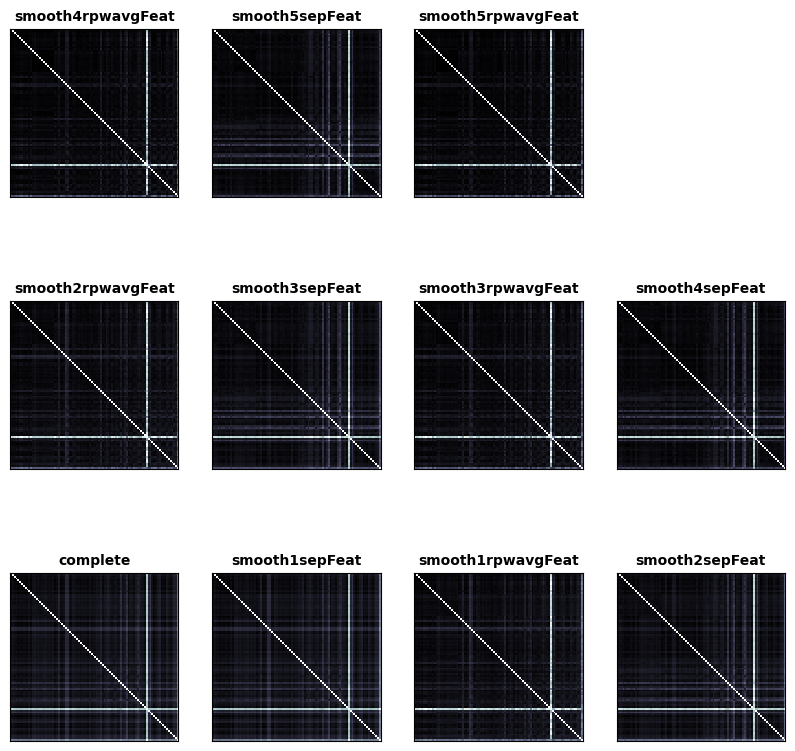

In [426]:
matlab_data = io.matlab.loadmat('/Users/h/Downloads/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
matlab_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])
matlab_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':matlab_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )

conv1_rdms = matlab_rdms.subset('brain_computational_model','conv1')
fig, ax, ret_val = rsatoolbox.vis.show_rdm(conv1_rdms, rdm_descriptor='measurement_model', figsize=(10,10))


In [435]:
model_rdms

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
None
dissimilarities = 
[[0.33333333 1.33333333 1.33333333 ... 0.33333333 1.33333333 0.33333333]
 [0.         0.         1.33333333 ... 0.         0.         0.        ]
 [0.33333333 1.33333333 1.33333333 ... 0.33333333 1.33333333 0.33333333]
 ...
 [0.25       1.         1.         ... 0.25       1.         0.25      ]
 [0.33333333 1.33333333 0.         ... 0.         0.         0.        ]
 [0.         0.         1.33333333 ... 0.         0.         0.        ]]
descriptors = 
{}
rdm_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 0], 'model_names': ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']}
pattern_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17], 'cond_names': 0          pain_high_cue_high_stim
1           pain_high_cue_med_stim
2           pain_high_cue_low_stim
3           pain_low_cue_high_stim
4            pain_low_cue_med_stim
5            pain_low_cue_low_stim
6     vic

In [385]:
r = []
for mod in model_rdms:
    r.append(rsatoolbox.rdm.compare(model_rdms, data_rdms, method='cosine'))


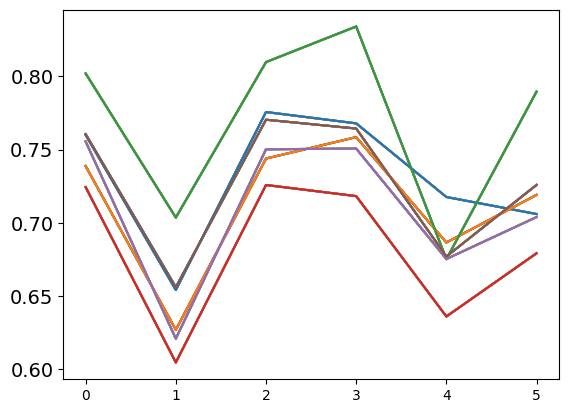

In [411]:

model_name= ['orthogonal', 'cue', 'grid', 'rotationgrid', 'diagonal', 'parallel']
for i, r_ in enumerate(r):
    plt.plot( r_.squeeze(), label=model_name[i])
            #  model_rdms[i].rdm_descriptors['model_names'][0])


In [392]:
results_1 = rsatoolbox.inference.eval_fixed(model_rdms, data_rdms, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

ValueError: model should be an rsatoolbox.model.Model or a list of such objects

In [558]:
results = rsatoolbox.inference.eval_fixed(model_rdms, data_rdms, method='corr_cov')
rsatoolbox.vis.plot_model_comparison(results)

ValueError: model should be an rsatoolbox.model.Model or a list of such objects

In [407]:
model_rdms[0].rdm_descriptors['model_names'][0]

'orthogonal'

In [395]:
model_rdms.to_dict().keys()

dict_keys(['dissimilarities', 'descriptors', 'rdm_descriptors', 'pattern_descriptors', 'dissimilarity_measure'])

In [564]:
type(model_rdms)

rsatoolbox.rdm.rdms.RDMs

In [562]:
i_model= 'conv1'
model_rdms.subset('brain_computational_model', i_model).subset('measurement_model','complete')

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
Euclidean
dissimilarities = 
[[7.35978432e+08 5.35502528e+08 6.70290560e+08 ... 1.85234202e+09
  4.90678682e+09 5.00813875e+09]]
descriptors = 
{}
rdm_descriptors = 
{'brain_computational_model': ['conv1'], 'measurement_model': ['complete'], 'index': [0]}
pattern_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]}

In [218]:
train_set, test_set, ceil_set = rsatoolbox.inference.sets_leave_one_out_rdm(data_rdms)
results_cv = rsatoolbox.inference.crossval(model, data_rdms, train_set, test_set, ceil_set=ceil_set, method='corr')

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/vis/model_plot.py:232: UserWarning: tests deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('tests deactivated as crossvalidation does not'
/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/rsatoolbox/vis/model_plot.py:238: UserWarning: errorbars deactivated as crossvalidation does notprovide uncertainty estimate
  warnings.warn('errorbars deactivated as crossvalidation does not'


(<Figure size 1250x1000 with 1 Axes>, <Axes:>, None)

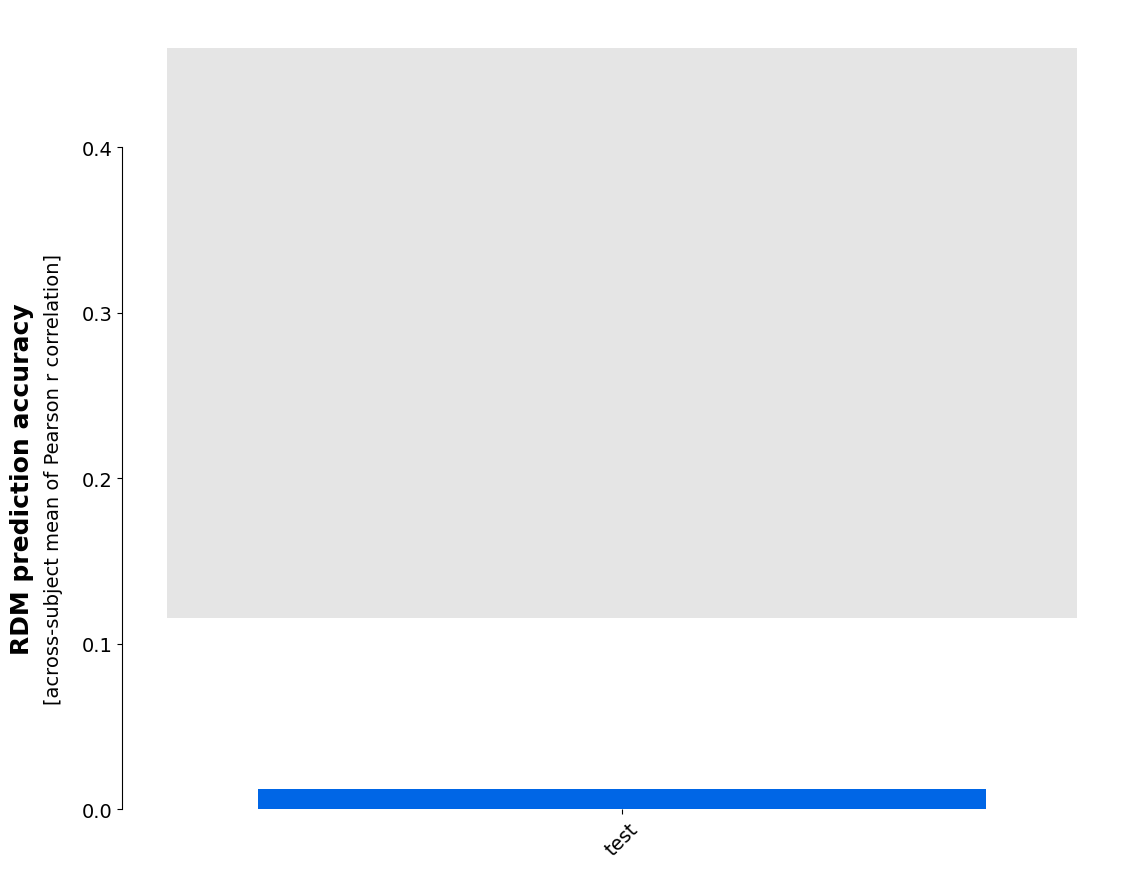

In [220]:
rsatoolbox.vis.plot_model_comparison(results_cv)

# demo

In [527]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           )


In [545]:
model_rdms[60]

rsatoolbox.rdm.RDMs(
dissimilarity_measure = 
Euclidean
dissimilarities = 
[[ 746706.875    284038.78125  455104.5625  ... 1020739.125
   836495.375    840631.875  ]]
descriptors = 
{}
rdm_descriptors = 
{'brain_computational_model': ['fc8'], 'measurement_model': ['rpwavgFeat'], 'index': [60]}
pattern_descriptors = 
{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]}

In [ ]:
# rsatoolbox.rdm.compare(method='rho-a')

# model = rsatoolbox.model.ModelWeighted('test', rdms)

In [70]:
# import rsatoolbox
# # generate 2 random model RDMs of 10 conditions
# model_features = [rsatoolbox.data.Dataset(np.random.rand(10, 7)) for i in range(2)]
# model_rdms = rsatoolbox.rdm.calc_rdm(model_features)
# model = rsatoolbox.model.ModelWeighted('test', model_rdms)

# # generate 5 random data RDMs of 10 conditions
# data = [rsatoolbox.data.Dataset(np.random.rand(10, 7)) for i in range(5)]
# data_rdms = rsatoolbox.rdm.calc_rdm(data)

# # fit model to group data to maximize cosine similarity using its default fitter
# theta = model.fit(data_rdms, method='cosine')

# # explicitly use the fit_optimize function to do the fit
# theta2 = rsatoolbox.model.fitter.fit_optimize(model, data_rdms, method='cosine')


In [231]:
singletrial_dir='/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
flist = glob.glob(os.path.join(singletrial_dir, 'sub-0080', '*stimulus*trial-000_*.nii.gz'))

In [235]:
# Initialize empty sets to store unique values of 'ses' and 'run'
unique_ses = set()
unique_run = set()

# Loop through each file path and extract 'ses-##' and 'run-##' using regular expressions
for path in flist:
    # Extract 'ses-##' using regular expression
    ses_match = re.search(r'ses-(\d+)', path)
    if ses_match:
        unique_ses.add(ses_match.group(0))

    # Extract 'run-##' using regular expression
    run_match = re.search(r'run-(\d+)', path)
    if run_match:
        unique_run.add(run_match.group(0))
for run in sorted(unique_run):
    print(run)